### Notebook for the generation of an annotated manifold for Ionocyte cells with `scANVI` 

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Systems Immunology (WüSI) - JMU-Würzburg**
- v231107

### Import required modules

In [1]:
import torch
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources NA
ipykernel         

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in Healthy data

In [5]:
epith_all = sc.read_h5ad('../../../data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad')
epith_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
epith_all.obs['cell_states'].cat.categories

Index(['APOD+Ciliated', 'IGFBP6+Basal', 'SERPINE1+Basal', 'SERPINE2+Basal',
       'CCDC3+Basal1', 'DHRS9+Club', 'FB-like_Basal', 'IGFBP+Basal',
       'ImmuneClub', 'Ionocyte', 'KRT14+AQP1+Secretory', 'KRT14+Goblet',
       'KRT17+Goblet', 'MHCII+Club', 'MKI67+pBasal', 'MUC5B+Goblet',
       'NOTCH+Basal2', 'NOTCH3+SupraB', 'OASiav_Ciliated', 'OMG+Ciliated',
       'RARRES1+lip_Goblet', 'S100A2+Basal', 'SCGB1+KRT5-FOXA1+iav_Club',
       'SCGB1A1+Deutero', 'SCGB1A1+Goblet', 'KRT16+SupraB', 'TCN1+Club',
       'TNC+Basal', 'iavAPC_Epi', 'iav-lip_Club', 'iav_Goblet', 'ifn_Basal',
       'ifn_Goblet', 'mixed_Goblet1', 'mixed_Goblet2', 'p53_Ciliated'],
      dtype='object')

In [7]:
epith_ionocytes = epith_all[epith_all.obs['cell_states'].isin(['Ionocyte'])]
epith_ionocytes

View of AnnData object with n_obs × n_vars = 621 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [28]:
epith_ionocytes.obs['cell_type'].cat.categories

Index(['club'], dtype='object')

In [8]:
epith_ionocytes.obs['seed_labels'] = epith_ionocytes.obs['cell_states'].copy()
epith_ionocytes.obs['seed_labels'].value_counts()

seed_labels
Ionocyte    621
Name: count, dtype: int64

### Relabel cells for annotation

In [9]:
non_healthy_ctrl_indices = epith_ionocytes.obs['group'] != 'healthy_ctrl'
epith_ionocytes.obs['seed_labels'] = epith_ionocytes.obs['seed_labels'].cat.add_categories('Unknown')
epith_ionocytes.obs.loc[non_healthy_ctrl_indices, 'seed_labels'] = 'Unknown'
epith_ionocytes.obs['seed_labels'].value_counts()

seed_labels
Unknown     480
Ionocyte    141
Name: count, dtype: int64

### Recalculate IAV-score

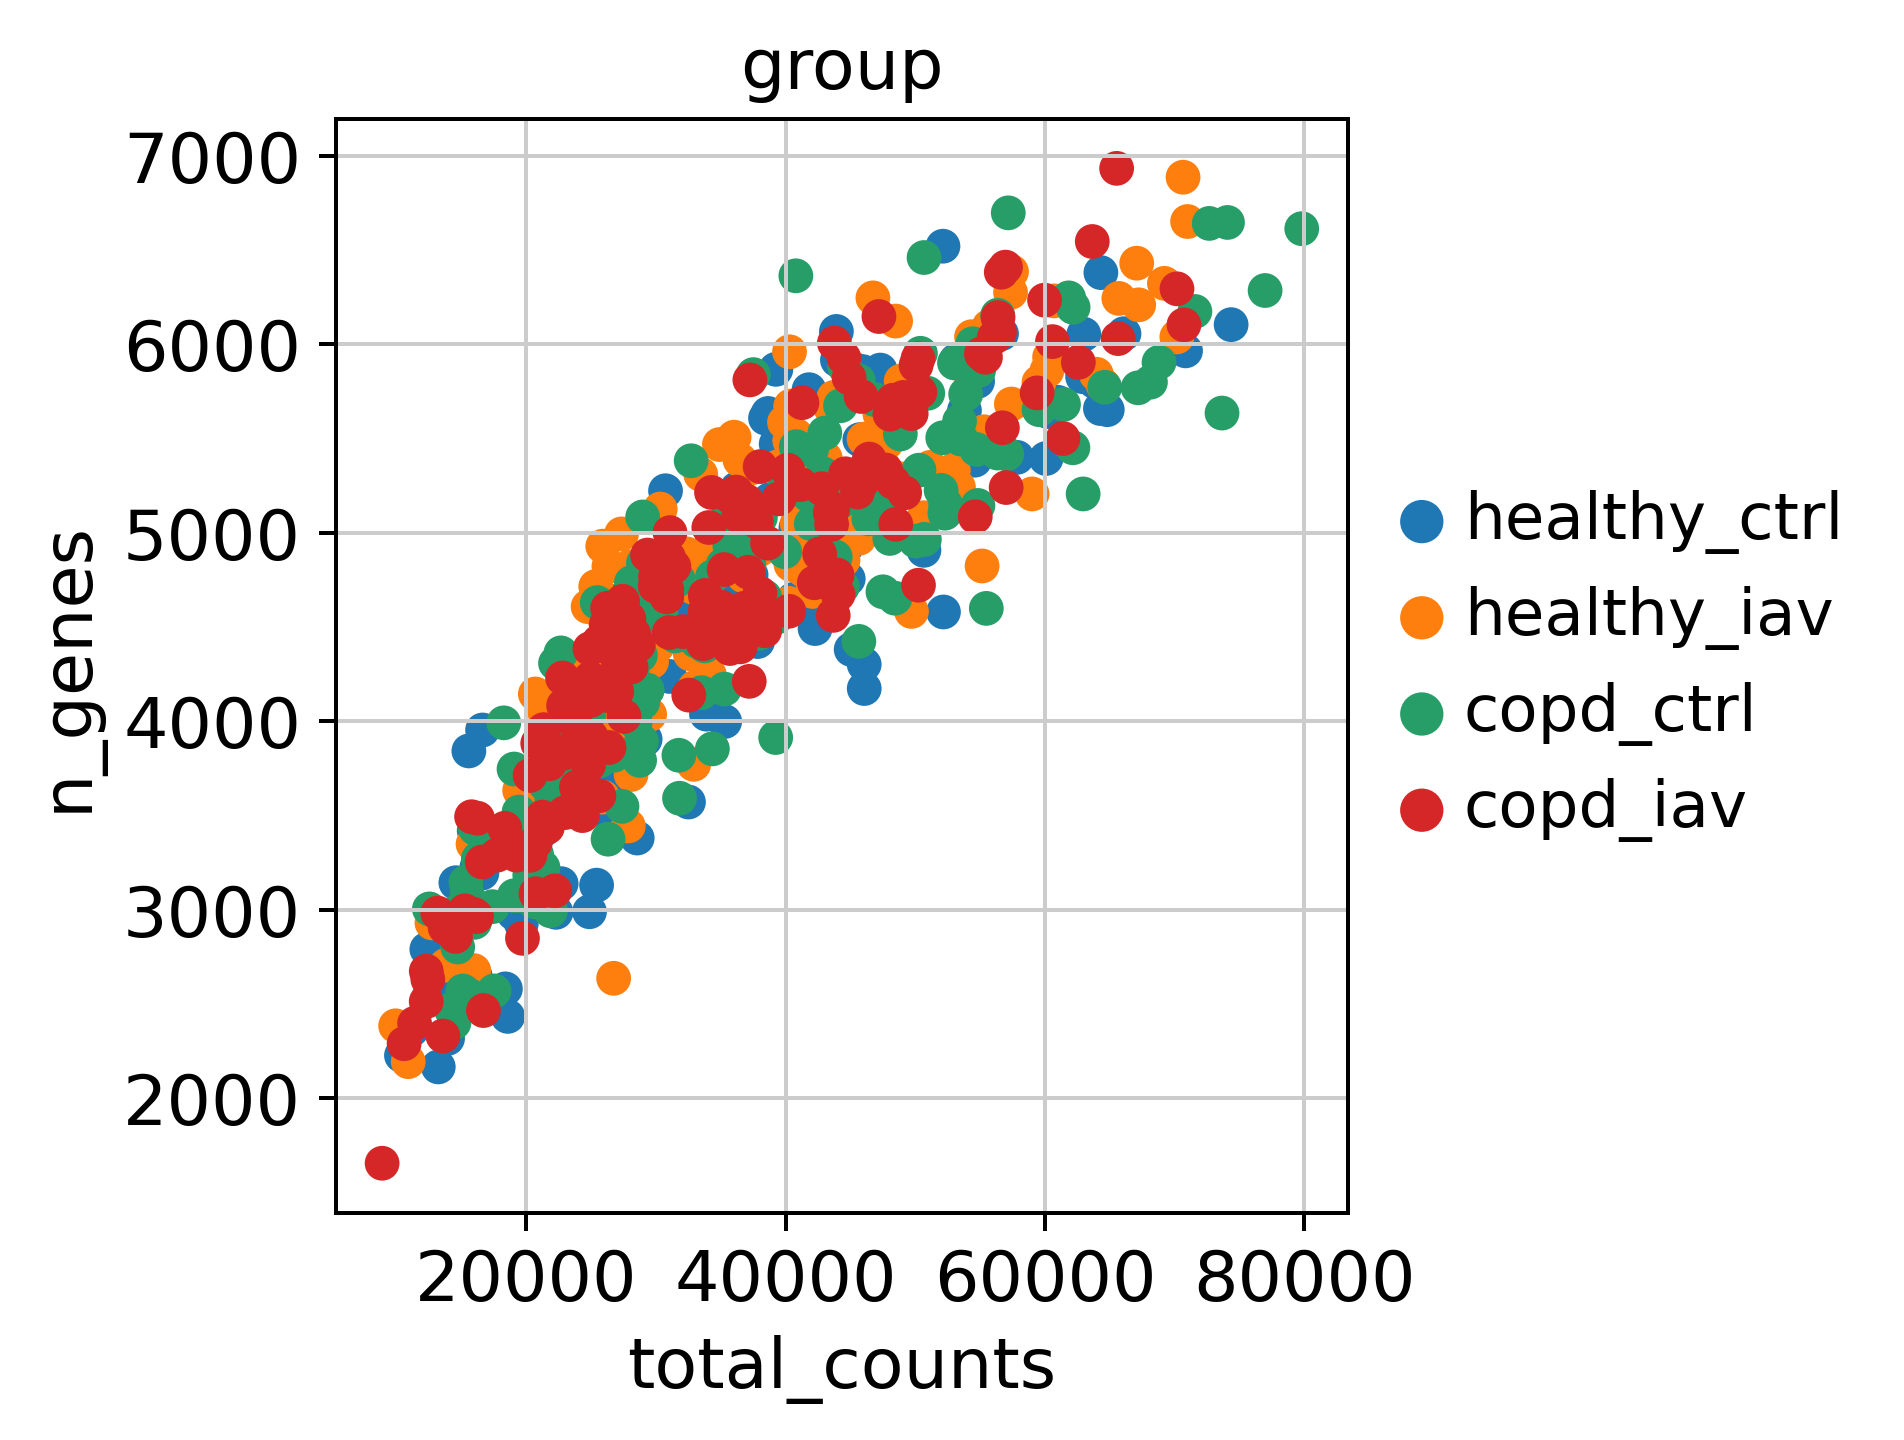

In [10]:
sc.pl.scatter(epith_ionocytes, x = 'total_counts', y = 'n_genes', color = "group", frameon = False)

In [11]:
nc_genes = epith_ionocytes.var_names[epith_ionocytes.var_names.str.startswith('NC_')]
print(nc_genes)

Index(['NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1',
       'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1'],
      dtype='object')


In [12]:
adata_log = epith_ionocytes.copy()

In [13]:
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)
sc.tl.score_genes(adata_log, nc_genes, score_name = 'Viral_score')

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-ND2', 'NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026436.1']
    finished (0:00:00)
computing score 'Viral_score'
    finished: added
    'Viral_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


In [15]:
epith_ionocytes.obs['Viral_score'] = adata_log.obs['Viral_score'].copy()
adata = epith_ionocytes.copy()

### Select HVGs

In [16]:
adata_raw = epith_ionocytes.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 621 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'group_colors', 'hvg'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'

### Transfer of annotation with scANVI

In [17]:
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys = ["donor"], labels_key = "seed_labels", layer = 'counts')

In [18]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [19]:
scvi_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|██████████| 400/400 [00:15<00:00, 30.06it/s, v_num=1, train_loss_step=8.12e+3, train_loss_epoch=7.74e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:15<00:00, 26.33it/s, v_num=1, train_loss_step=8.12e+3, train_loss_epoch=7.74e+3]


In [20]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Label transfer with `scANVI` 

In [21]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [22]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


ValueError: Expected argument `num_classes` to be an integer larger than 1, but got 1

In [ ]:
adata.obs["C_scANVI_v2"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


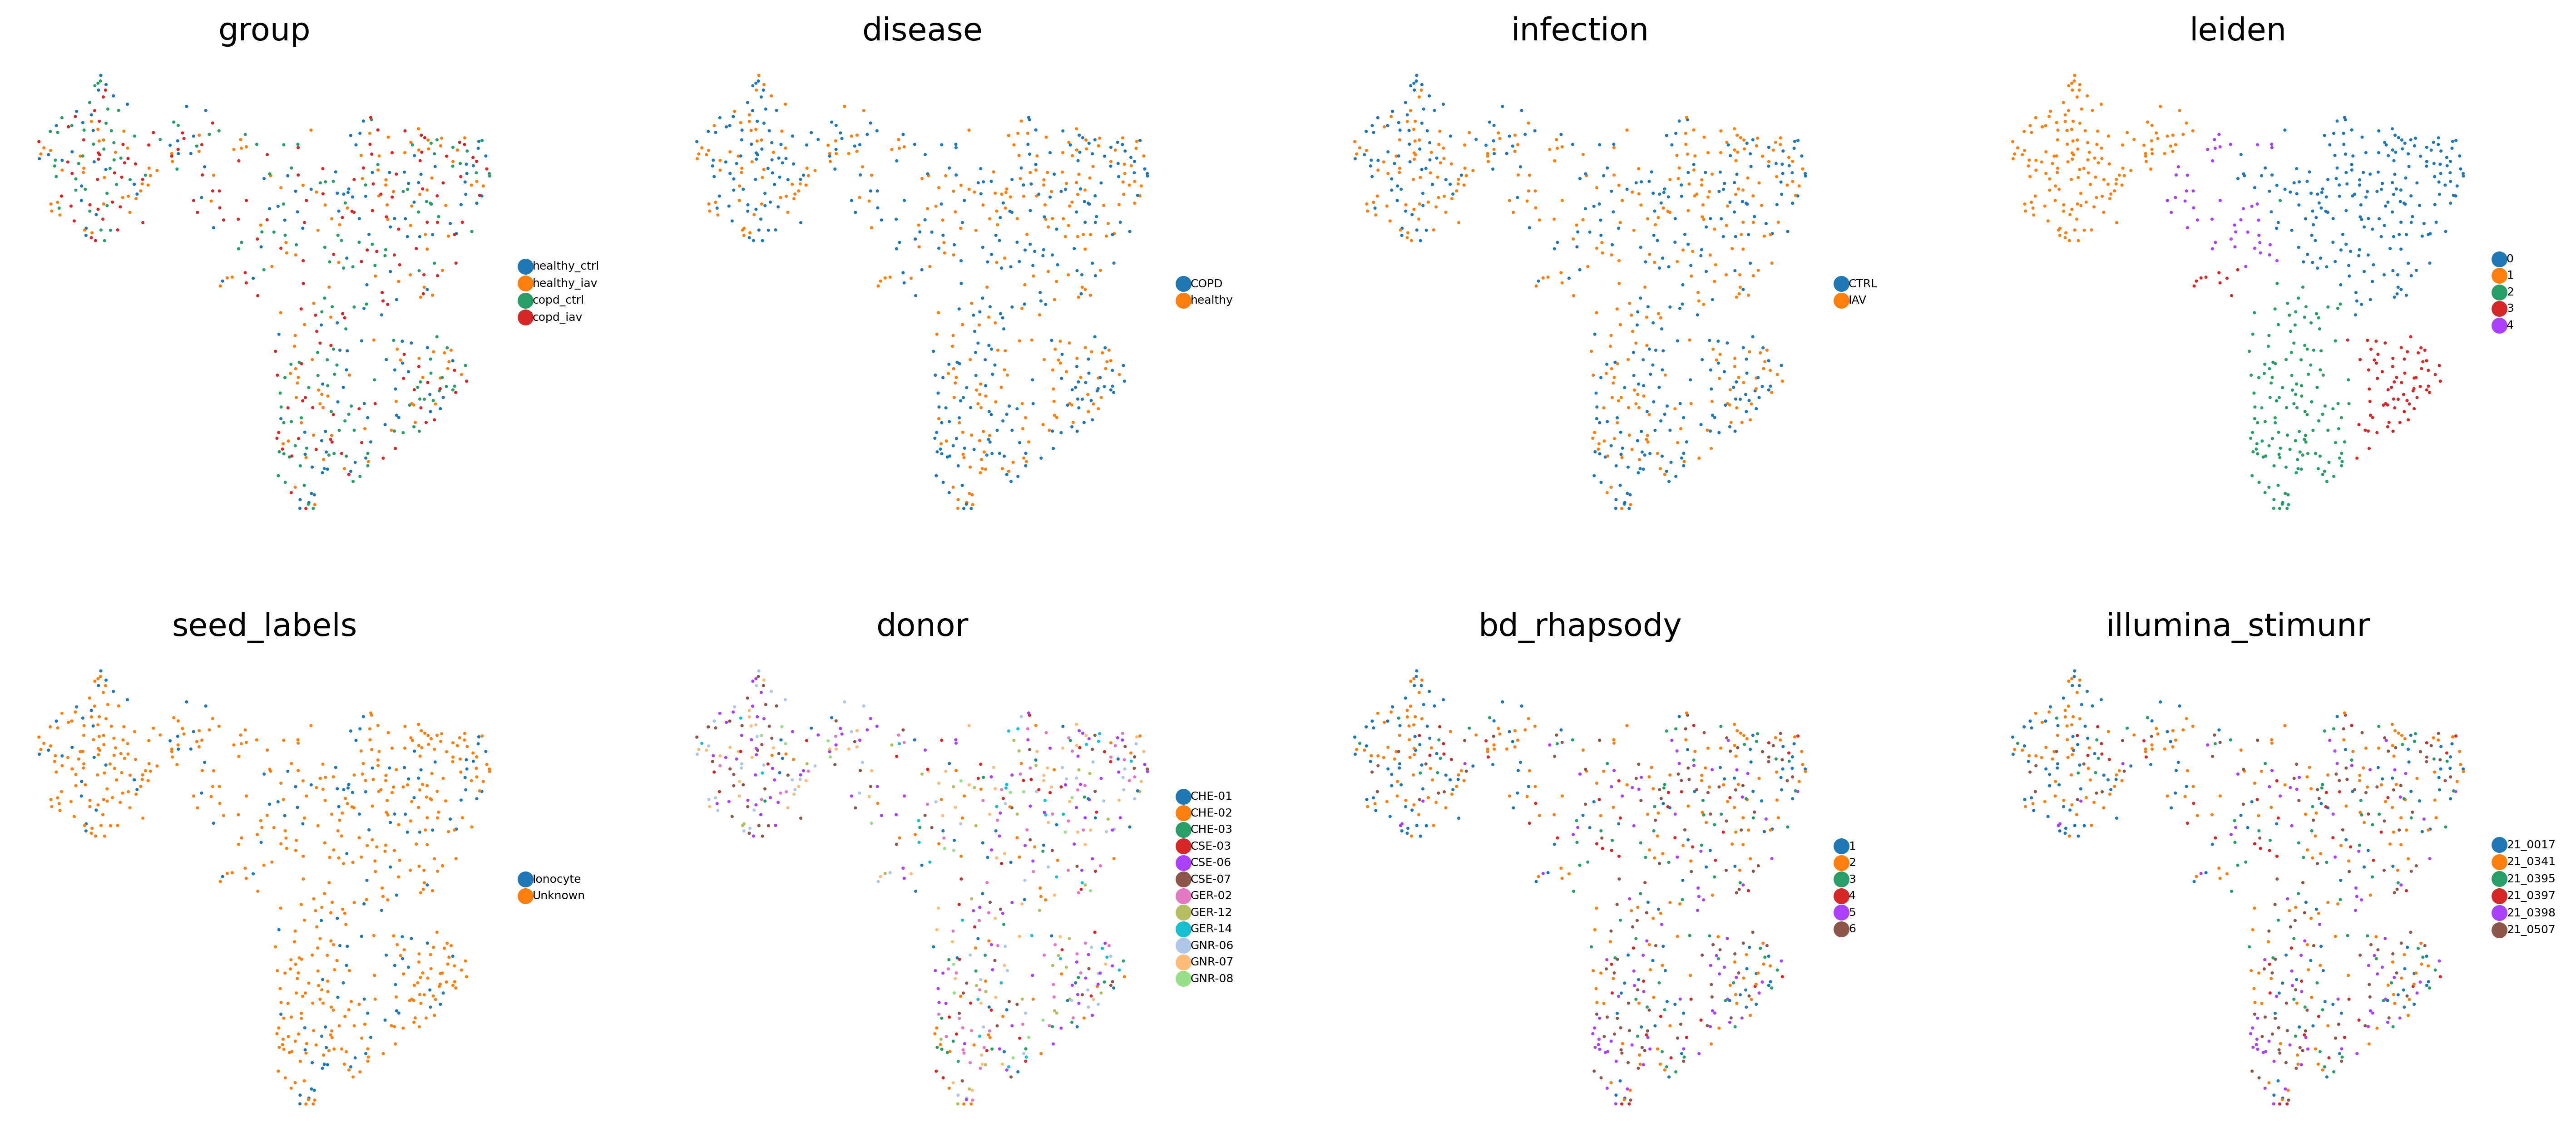

In [32]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.leiden(adata, resolution = 0.6, random_state = 1769)
sc.tl.umap(adata, min_dist = 0.4, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['group', 'disease', 'infection', 'leiden', 'seed_labels', 'donor', 'bd_rhapsody', 'illumina_stimunr'], size = 8, legend_fontsize = 5, ncols = 4)

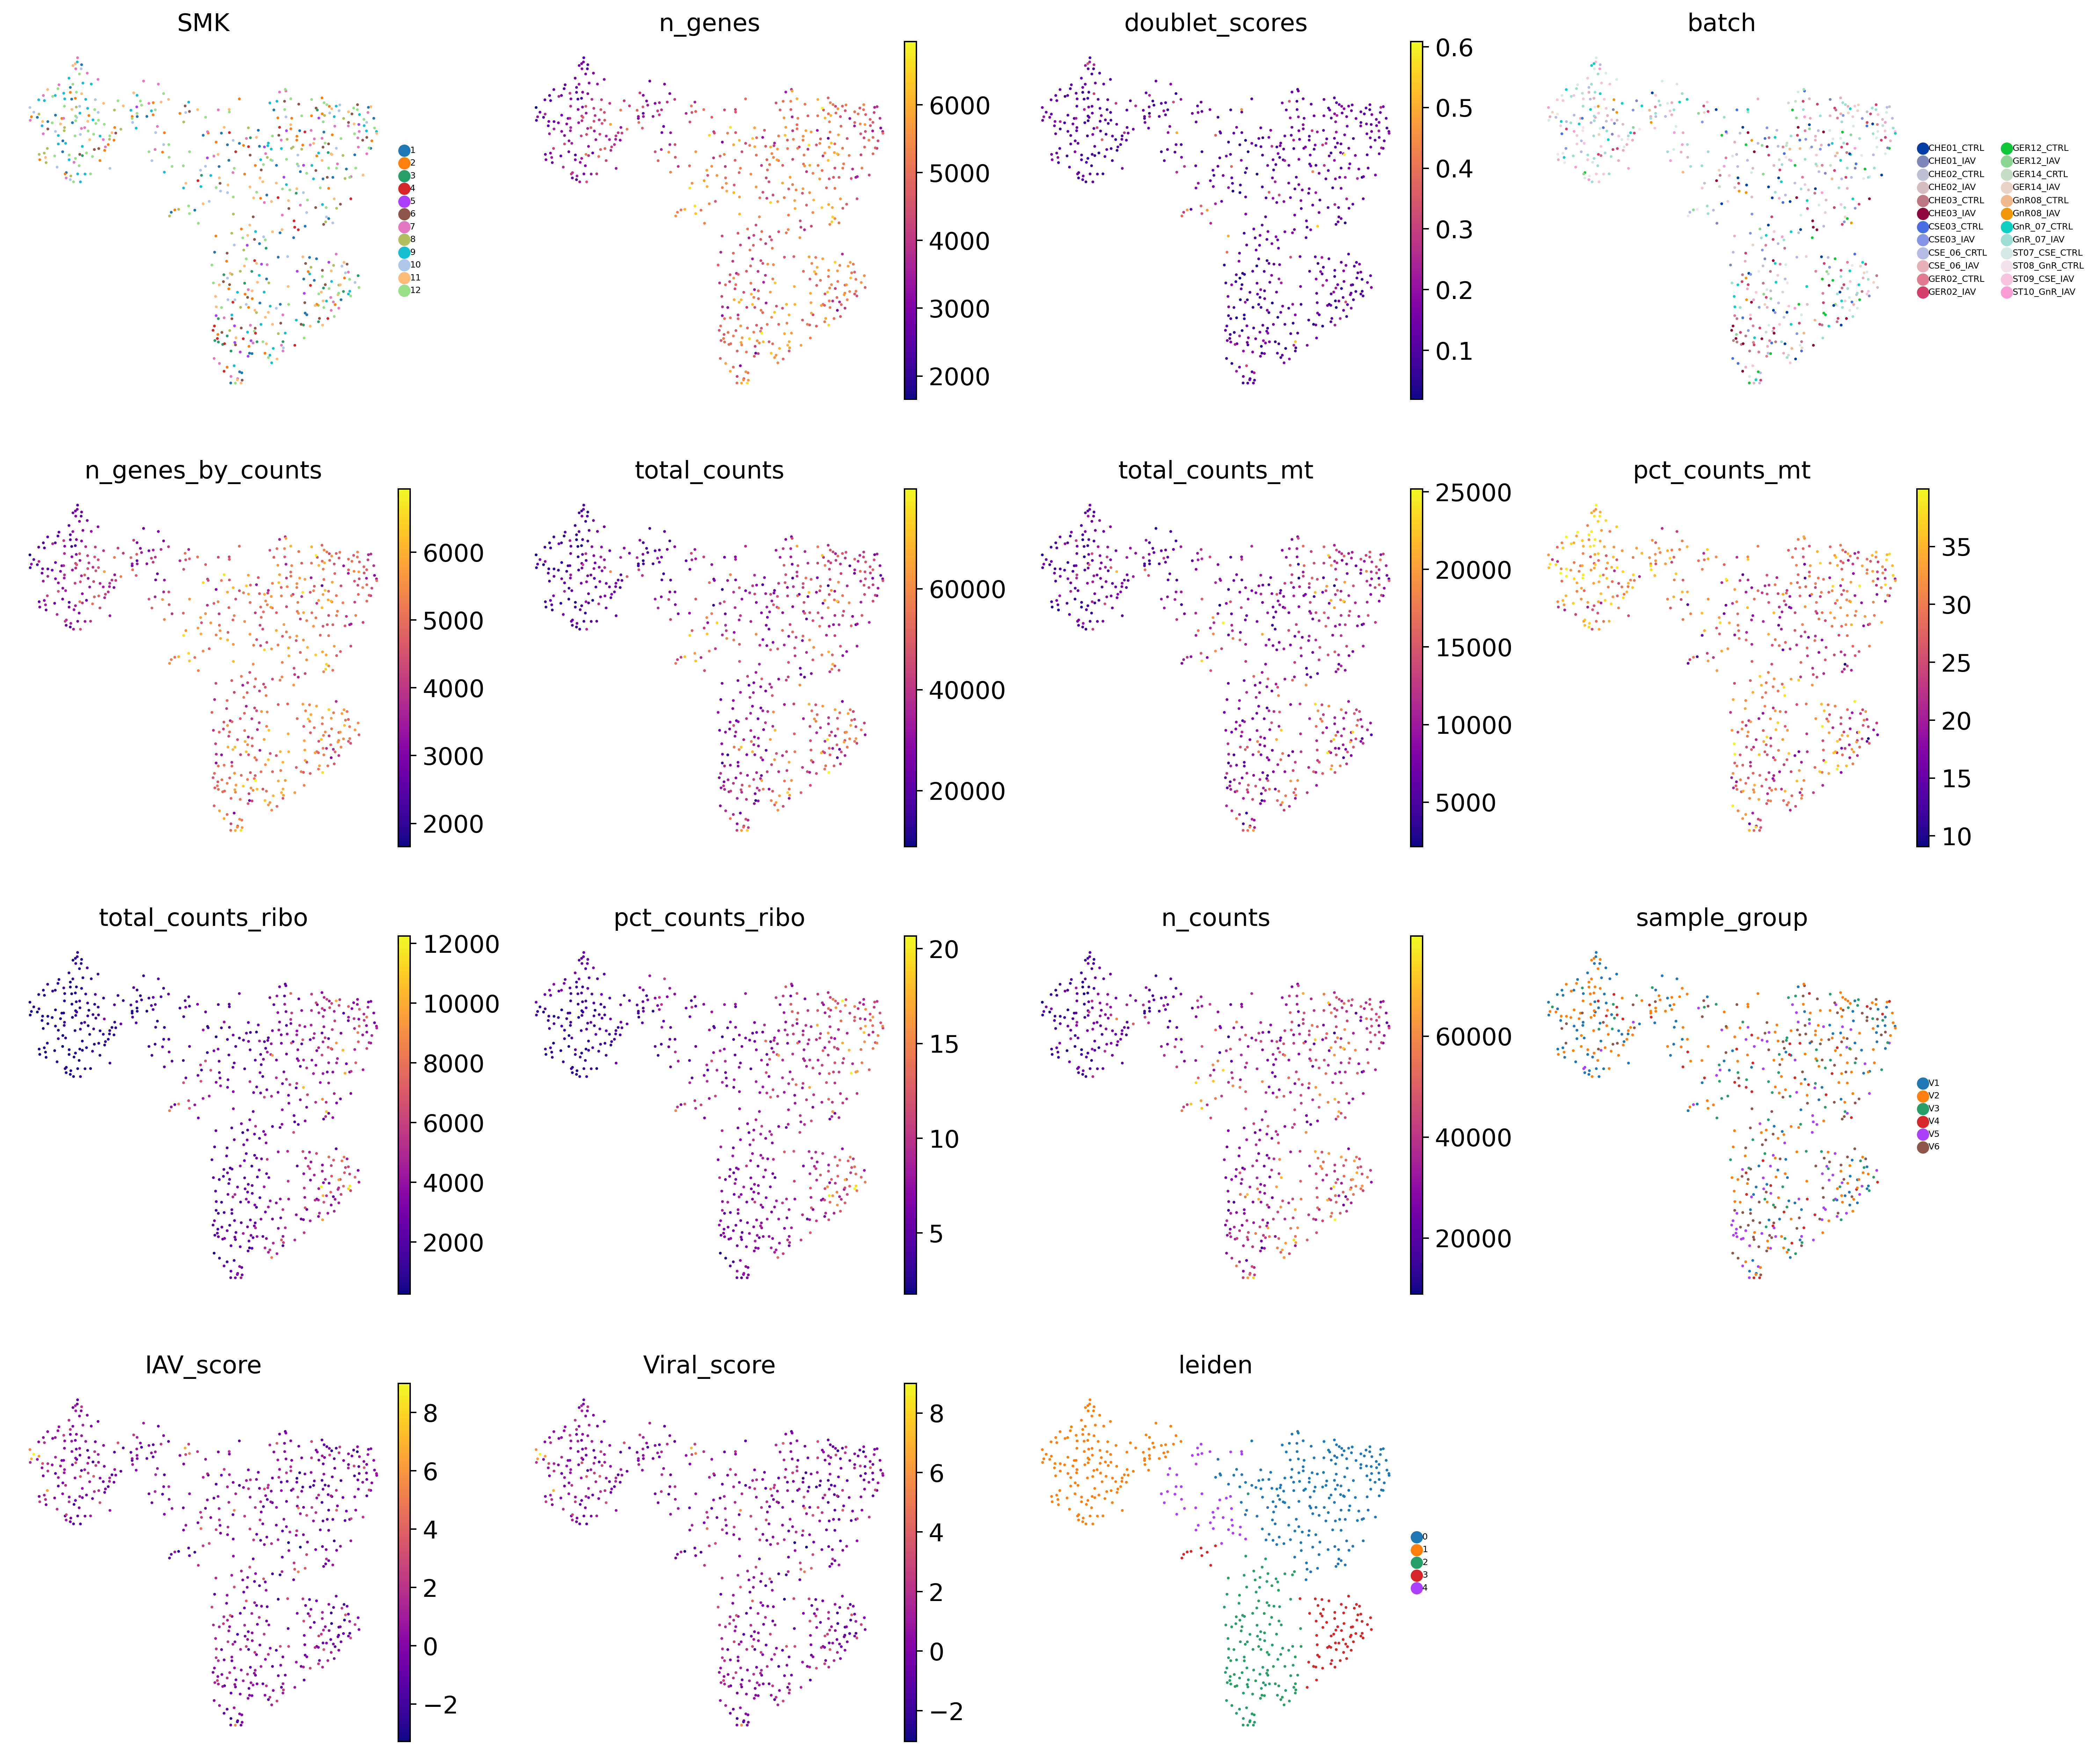

In [34]:
sc.pl.umap(adata, frameon = False, color = ['SMK', 'n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'sample_group', 'IAV_score', 'Viral_score', 'leiden'], size = 10, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Visualise individual genes using new manifold 

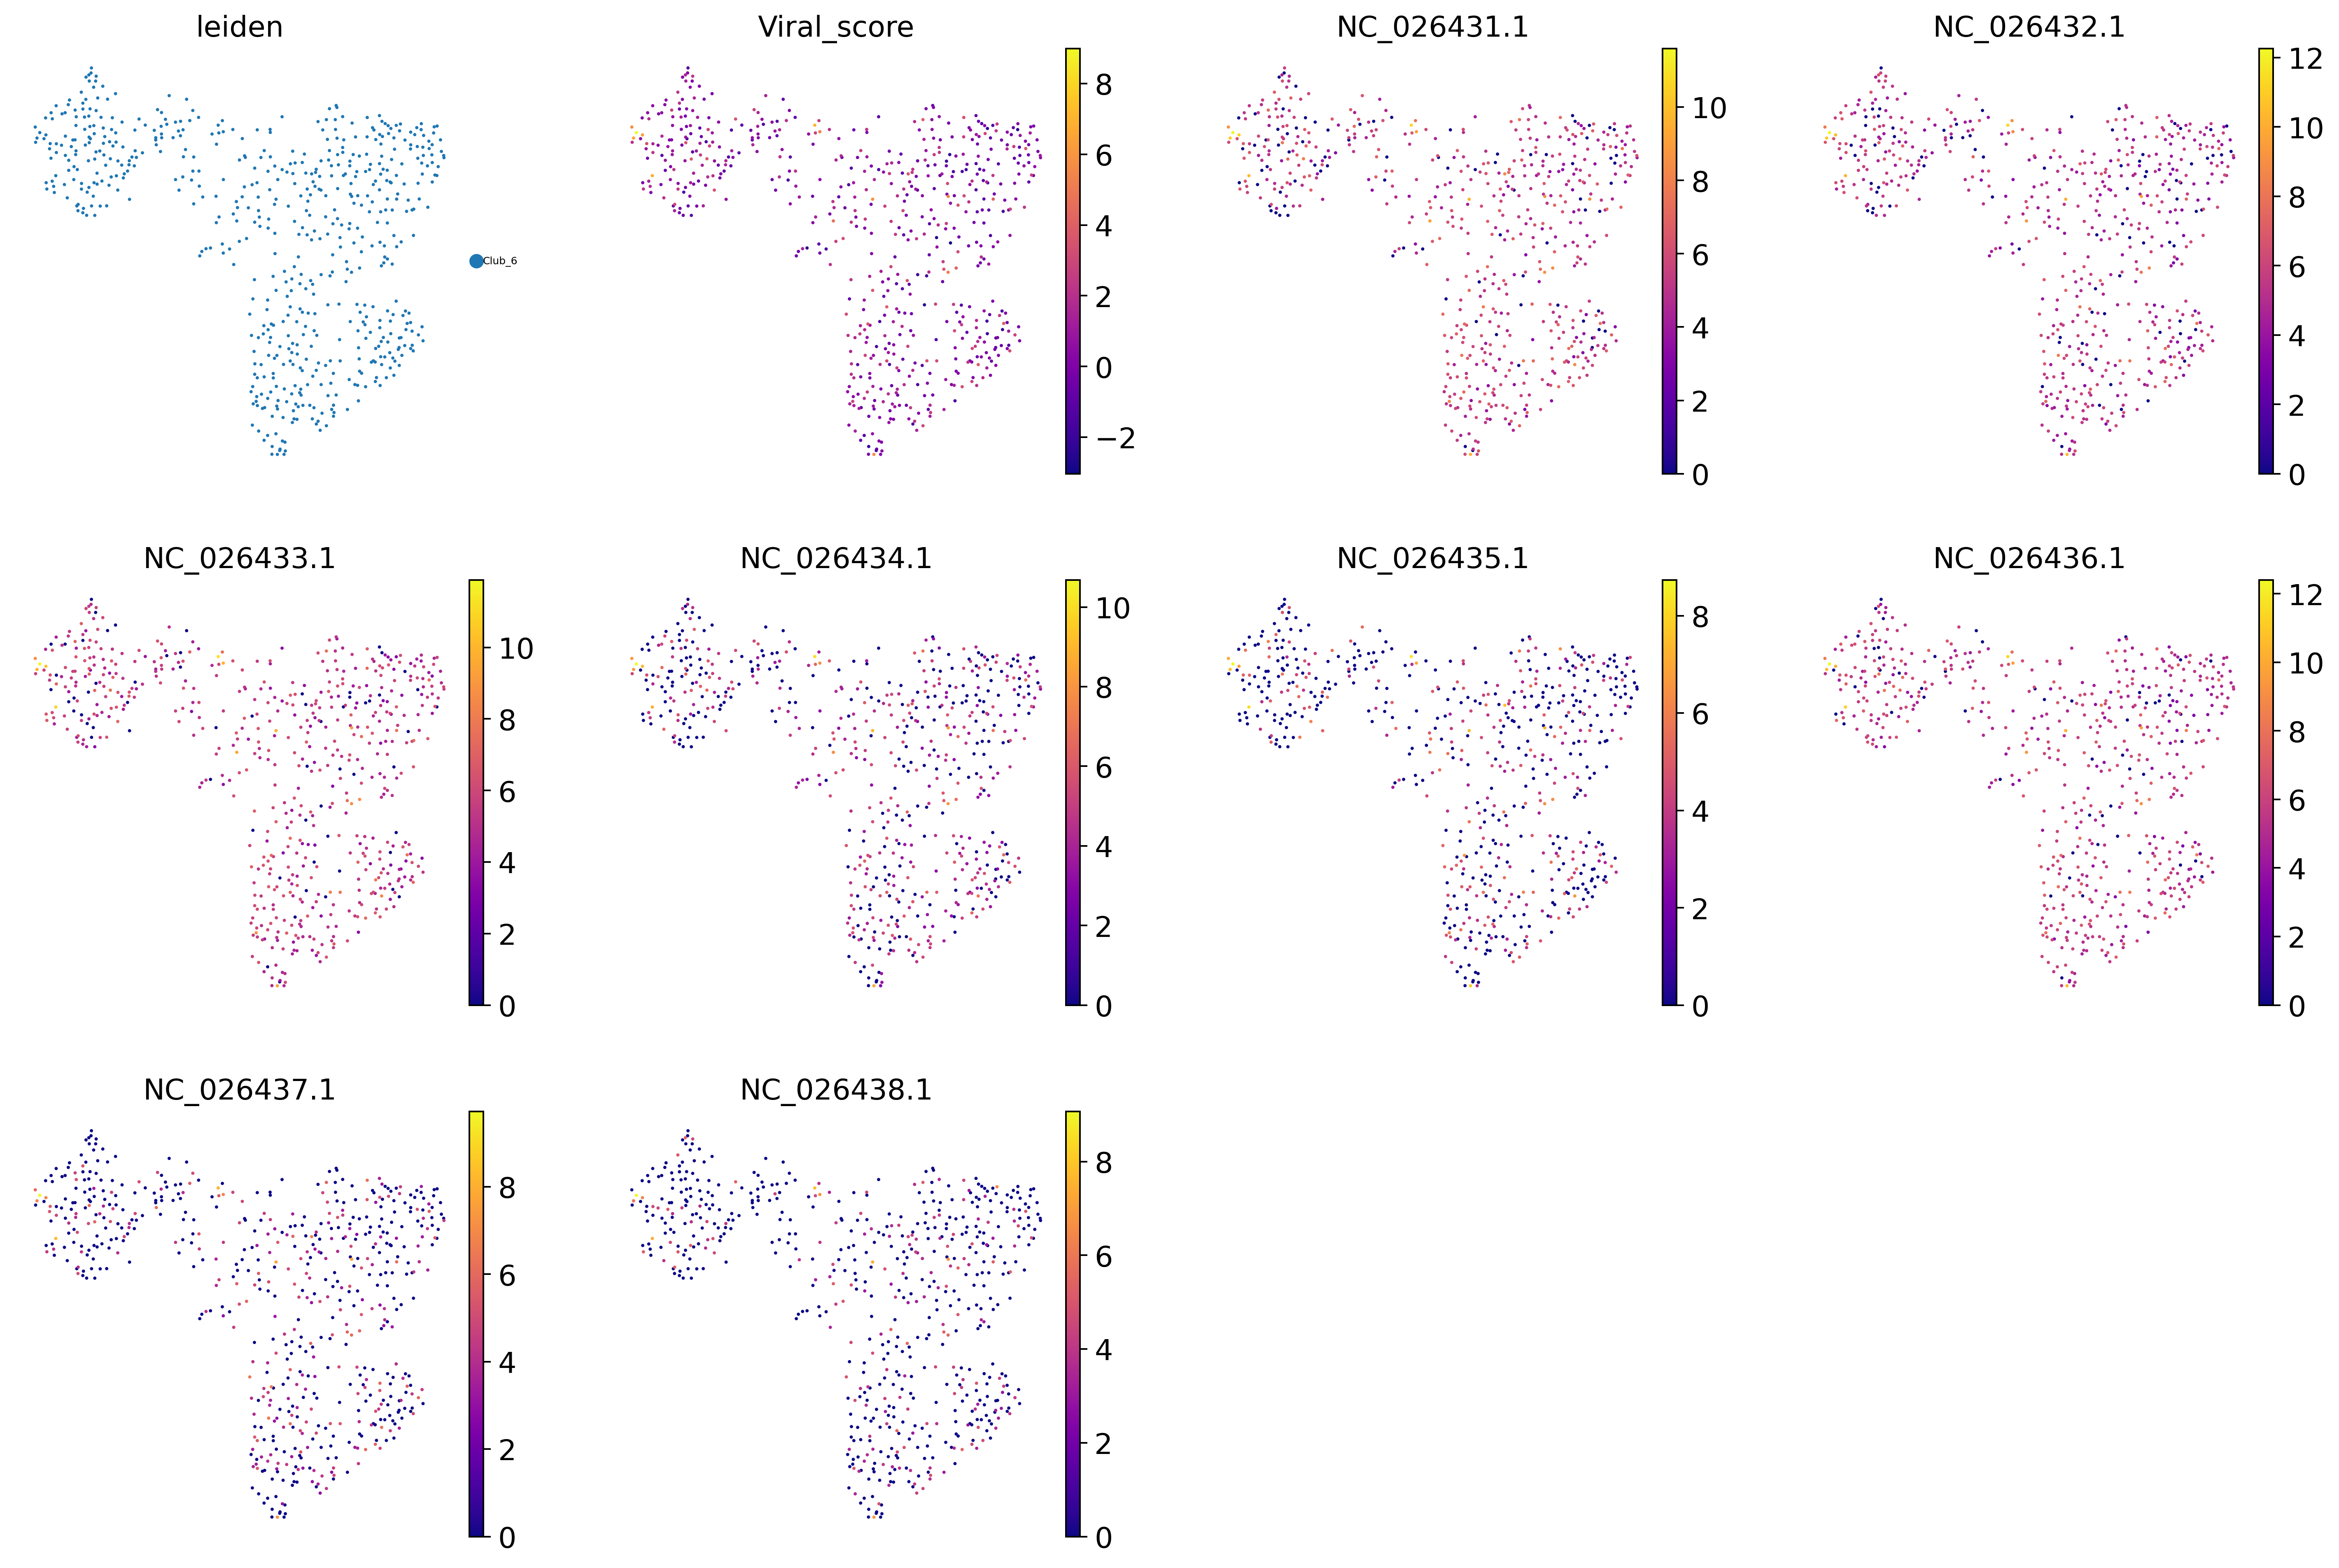

In [36]:
adata_log.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_log.obsm['X_umap'] = adata.obsm['X_umap'].copy()

sc.pl.umap(adata_log, frameon = False, color = ['leiden', 'Viral_score', 'NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1'], size = 10, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Compute integration metrics

In [ ]:
bm = Benchmarker(
    adata,
    batch_key = ["donor"],
    label_key = "C_scANVI_v2",
    embedding_obsm_keys = ["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Export annotated sample object 

In [37]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

Index(['691353-ST07_CSE_CTRL-V1', '742253-ST07_CSE_CTRL-V1',
       '575997-ST07_CSE_CTRL-V1', '280598-ST07_CSE_CTRL-V1',
       '15063-ST07_CSE_CTRL-V1', '866704-ST07_CSE_CTRL-V1',
       '81899-ST07_CSE_CTRL-V1', '562175-ST07_CSE_CTRL-V1',
       '27740-ST07_CSE_CTRL-V1', '229956-ST07_CSE_CTRL-V1',
       ...
       '7396320-CSE03_IAV-V6', '12125989-CSE03_IAV-V6', '5776555-CSE03_IAV-V6',
       '1482702-CSE03_IAV-V6', '9175371-CSE03_IAV-V6', '13567561-CSE03_IAV-V6',
       '3693010-CSE03_IAV-V6', '7395097-CSE03_IAV-V6', '2241504-CSE03_IAV-V6',
       '13892781-CSE03_IAV-V6'],
      dtype='object', length=621)

In [38]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

Index(['691353-ST07_CSE_CTRL-V1', '742253-ST07_CSE_CTRL-V1',
       '575997-ST07_CSE_CTRL-V1', '280598-ST07_CSE_CTRL-V1',
       '15063-ST07_CSE_CTRL-V1', '866704-ST07_CSE_CTRL-V1',
       '81899-ST07_CSE_CTRL-V1', '562175-ST07_CSE_CTRL-V1',
       '27740-ST07_CSE_CTRL-V1', '229956-ST07_CSE_CTRL-V1',
       ...
       '7396320-CSE03_IAV-V6', '12125989-CSE03_IAV-V6', '5776555-CSE03_IAV-V6',
       '1482702-CSE03_IAV-V6', '9175371-CSE03_IAV-V6', '13567561-CSE03_IAV-V6',
       '3693010-CSE03_IAV-V6', '7395097-CSE03_IAV-V6', '2241504-CSE03_IAV-V6',
       '13892781-CSE03_IAV-V6'],
      dtype='object', length=621)

In [39]:
adata.obs_names

Index(['691353-ST07_CSE_CTRL-V1', '742253-ST07_CSE_CTRL-V1',
       '575997-ST07_CSE_CTRL-V1', '280598-ST07_CSE_CTRL-V1',
       '15063-ST07_CSE_CTRL-V1', '866704-ST07_CSE_CTRL-V1',
       '81899-ST07_CSE_CTRL-V1', '562175-ST07_CSE_CTRL-V1',
       '27740-ST07_CSE_CTRL-V1', '229956-ST07_CSE_CTRL-V1',
       ...
       '7396320-CSE03_IAV-V6', '12125989-CSE03_IAV-V6', '5776555-CSE03_IAV-V6',
       '1482702-CSE03_IAV-V6', '9175371-CSE03_IAV-V6', '13567561-CSE03_IAV-V6',
       '3693010-CSE03_IAV-V6', '7395097-CSE03_IAV-V6', '2241504-CSE03_IAV-V6',
       '13892781-CSE03_IAV-V6'],
      dtype='object', length=621)

In [40]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4'], dtype='object')

In [41]:
adata.obs['leiden'].value_counts()

leiden
0    205
1    152
2    142
3     78
4     44
Name: count, dtype: int64

### Export annotated object with raw counts

In [42]:
adata

AnnData object with n_obs × n_vars = 621 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'group_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'disease_colors', 'infection_colors', 'C_scANVI_colors', 'leiden', 'leiden_colors', 'seed_labels_colors', 'donor_colors', 'bd_rhapsody_colors', 'illumina_stimunr_colors', 'SM

In [43]:
adata_raw

AnnData object with n_obs × n_vars = 621 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    uns: 'group_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [44]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var, uns = adata_raw.uns, obsp = adata_raw.obsp)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export

AnnData object with n_obs × n_vars = 621 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    uns: 'group_colors'
    obsm: 'X_scVI', 'X_umap'

In [46]:
adata_export_log = adata_export.copy()
sc.pp.normalize_total(adata_export_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_export_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-ND2', 'NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026436.1']
    finished (0:00:00)


In [45]:
adata_export.write('../../../data/Ionocytes_ctl231107_scVI_clustered.raw.h5ad')

In [47]:
adata_export_log.write('../../../data/Ionocytes_ctl231107_scVI_clustered.log.h5ad')

In [48]:
sc.tl.rank_genes_groups(adata_export_log, 'leiden', method = 'wilcoxon', n_genes = 100, use_raw = False)
result = adata_export_log.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcox_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
wilcox_markers.head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


0_n       0_l           0_p        1_n       1_l           1_p      2_n  \
0    NREP  6.115401  8.858475e-62  TMPRSS11E  8.466147  5.517173e-65    WFDC2   
1     MYB  6.000918  1.956728e-52     ATP1A1  3.475049  2.162933e-62   CXCL17   
2    LRMP  4.863066  1.926959e-47       CFTR  9.376055  2.347097e-59  CEACAM6   
3   AZGP1  5.633689  6.783414e-45      RCAN2  9.178877  4.683105e-59     SLPI   
4   ANXA1  3.120256  1.212376e-44    ATP6V1A  2.873470  9.733826e-58     CD74   
5  POU2F3  5.427632  1.212376e-44       NGFR  7.384552  2.042417e-55     LCN2   
6   STMN1  4.714494  1.721268e-38        CD9  2.770448  6.246324e-54  SLC34A2   
7   ASCL2  5.074529  2.229692e-34    TFCP2L1  4.261588  2.218194e-51   TSPAN1   
8    YBX1  0.780682  3.091787e-33    ATP6V0B  1.611308  3.296808e-46       CP   
9   ANXA4  1.299402  4.568846e-32       CNN3  2.068330  5.429569e-45    S100P   

        2_l           2_p        3_n       3_l           3_p      4_n  \
0  3.001623  1.012652e-42    S100A11  1.697904  1.852874e-23   ATP2A3   
1  3.230303  2.341101e-40  SERPINB13  5.614088  1.249132e-21    H3F3B   
2  5.667757  3.447641e-39     S100A2  2.932713  1.746677e-21   TSPAN6   
3  2.987718  1.109879e-37      ANXA2  0.914297  2.686526e-21    ABHD2   
4  3.185786  7.016991e-35     CRABP2  4.411631  9.229517e-20  TMEM213   
5  3.666746  1.115902e-34       TPT1  0.784009  4.983229e-19   SLC51A   
6  5.093322  1.801728e-33   SERPINB4  5.548083  2.438665e-18    SP110   
7  3.365940  3.219617e-33   SERPINB5  4.005963  9.548124e-17    SSBP3   
8  5.034083  4.283311e-33       RPS8  0.911178  7.958078e-16    ASCL3   
9  4.700521  1.278597e-31      RPL34  0.880467  1.923983e-15     KRT8   

        4_l       4_p  
0  3.762369  0.000007  
1  0.724742  0.000033  
2  1.798896  0.000056  
3  1.929531  0.000056  
4  6.232414  0.000089  
5  3.148979  0.000089  
6  2.920989  0.000089  
7  2.048320  0.000105  
8  4.861268  0.000105  
9  0.957847  0.000394

In [49]:
wilcox_markers.to_csv('../../../data/Ionocytes_ctl231107_DEG_WRST.csv', sep = ',', index = False)